The following file reads a number of files in a specific format "heightmaps_sequence-?_impacts-?_coverage-?.csv"
where ? are integers representing different samples for the numerical simuilation. 
Then the conventional as well as persistence parameters are calculated.

1) Section: 
The values of the hyperparameters are extracted and the values on the grids specified in the files are saved.

2) For an analysis we need to interpolate the samples on a regular grid.

3) Estimate coverage values

In [2]:
%load_ext autoreload
%autoreload 2

# change current working directory to parent folder, to execute script as if we execute ther
%pwd
%cd ..

/Users/janfelixsenge/GitBucket/github_tda_shotpeening/tda_shotpeening/tda_shotpeening


In [3]:
import numpy as np
import pandas as pd
import time

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# import path variables
from src.config import data_path_raw_simulation, data_path_interim
# import simulation parameters
from src.config import simulation_parameters

# import the read and check method files
from src.preprocess.read_simulation_files import (read_heightmaps_sequences, check_if_regulargrid,
    interpolate_grid, interpolate_regular_grid)

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# import path variables
from src.config import data_path_interim, data_path_processed
# import simulation parameters
from src.config import simulation_parameters

#
from src.parameters.areal_surface_parameter import getRoughnessParams
from src.parameters.persistence_parameters import getPersistence, persistence_parameters
from src.postprocessing import wrapper_postprocess


In [10]:
def get_descriptor_conv(z, x, y, 
                        interpolation_pre,
                        interpolation_post,
                        removeplane,
                        use_filter):

    if interpolation_pre == 0:
        znew = z
        ynew = y[0]
        xnew = x[0]
        print('not interpolated')

    else:
        znew, xnew, ynew = interpolate_regular_grid(z, x, y, 
                                interpolation_pre, 
                                bigger_grid=simulation_parameters['bigger_grid'])
        
    processed = simulation_parameters['simulation_processed']
    print('Processing of the surface is done using:', processed)
    print('Remove a least square fitted plane from surface:', removeplane)
    print('Use gausian filter:', use_filter)
    print('Inteprolation postproces:', interpolation_post)

    t0 = time.time()
    znew, xnew, ynew = wrapper_postprocess(znew,
                                        xnew,
                                        ynew,
                                        removeplane=removeplane,
                                        use_filter=use_filter,
                                        interpolation_size=interpolation_post,
                                        cut_matrix=2,
                                        dimension=2)
    print(f'Postprocessing took {time.time() - t0} seconds.')

    # Now calculate the parameter values for the conventional parameters
    t0 =time.time()

    df_conventional = getRoughnessParams(znew, xnew, ynew,
                                        version='all',
                                        shift=True)

    print(f'Calculating conventional parameters took {time.time() - t0} seconds.')

    return (df_conventional)

# 1) read xlsv data

In [23]:
testpath = Path('./test/test_numerical_simulation/')

data = []
count = 0
x_vals = []
y_vals = []
z_vals = []
for x in tqdm(testpath.iterdir()):
    if x.is_file() and 'heightmap_sequence-' in x.name:
        tmp = {'sequence': int(x.name.split('_')[1].split('-')[1]),
                'impacts': int(x.name.split('_')[2].split('-')[1]),
                'coverage': int(x.name.split('_')[3].split('-')[1].split('.')[0]),
                'id': count
                }
        data.append(tmp)
        count += 1
        
        df_tmp = pd.read_excel(x, engine='openpyxl')
        # drop NaN columns and rows if they only contain Nan values
        df_tmp.dropna(axis=0, how='all', inplace=True)
        df_tmp.dropna(axis=1, how='all', inplace=True)

        df_tmp.columns = [name.strip() for name in df_tmp.columns]
        # columns might be named 'x','y' or 'x0','y0' etc
        if 'x' in df_tmp.columns:
            df_tmp.sort_values(['x', 'y'], inplace=True)
            x = df_tmp['x'].iloc[:].to_numpy()
            y = df_tmp['y'].iloc[:].to_numpy()
            check = df_tmp['z'].iloc[:].to_numpy()
        else:
            df_tmp.sort_values(['x0', 'y0'], inplace=True)
            x = df_tmp['x0'].iloc[:].to_numpy()
            y = df_tmp['y0'].iloc[:].to_numpy()
            check = df_tmp['z0'].iloc[:].to_numpy()
        
        # check if the values span a regular grid and z's are constant
        if not (check == check[0]).all():
            print('For entry {} the z-values are not constant!'.format(i))

        x_uni = np.unique(x)  # array is already sorted
        y_uni = np.unique(y)  # array is already sorted

        # check if grid is "regular enough"
        test = x_uni[1:] - x_uni[:-1]
        if not (np.abs(test - test[0]) < 0.1**7).all():
            print('For entry {} the x-grid is not regular enough!'.format(i))
        test = y_uni[1:] - y_uni[:-1]
        if not (np.abs(test - test[0]) < 0.1**7).all():
            print('For entry {} the y-grid is not regular enough!'.format(i))

        #
        for xii in x_uni:
            if not (y[x == xii].size == y_uni.size):
                print('For entry {} y-values are not evenly spread!'.format(i))
        # unnecessary, but double check
        for yii in y_uni:
            if not (x[y == yii].size == x_uni.size):
                print('For entry {} x-values are not evenly spread!'.format(i))

        # assign the valus after successfull check
        x_vals.append(x.reshape(x_uni.size, y_uni.size))
        y_vals.append(y.reshape(x_uni.size, y_uni.size))
        z_vals.append(df_tmp['U3'].iloc[:].to_numpy().reshape(x_uni.size,
                                                            y_uni.size))

# last check:
for i in range(1, len(x_vals)):
    if np.shape(z_vals[i]) != np.shape(z_vals[0]):
        print('Shape of data are not the same for all samples (see {})!'
                .format(i))
    elif not (np.abs(x_vals[i] - x_vals[0]) < 0.1**7).all():
        print('For x-values are not the same for all samples (see {})!'
                .format(i))
    elif not (np.abs(y_vals[i] - y_vals[0]) < 0.1**7).all():
        print('For y-values are not the same for all samples (see {})!'
                .format(i))
    else:
        z_vals = np.array(z_vals)
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)


df_meta = pd.DataFrame(data)

30it [00:16,  1.86it/s]


In [45]:
df_meta.head()

,sequence,impacts,coverage,id
0,0,24,83,0
1,4,25,83,1
2,4,5,16,2
3,1,25,83,3
4,3,10,33,4


In [24]:
df_meta = df_meta.sort_values(by=['sequence', 'impacts'])
df_meta.head(10)

,sequence,impacts,coverage,id
24,0,4,16,24
23,0,9,33,23
9,0,14,50,9
18,0,19,66,18
0,0,24,83,0
12,0,29,100,12
27,1,5,16,27
15,1,10,33,15
5,1,15,50,5
6,1,20,66,6


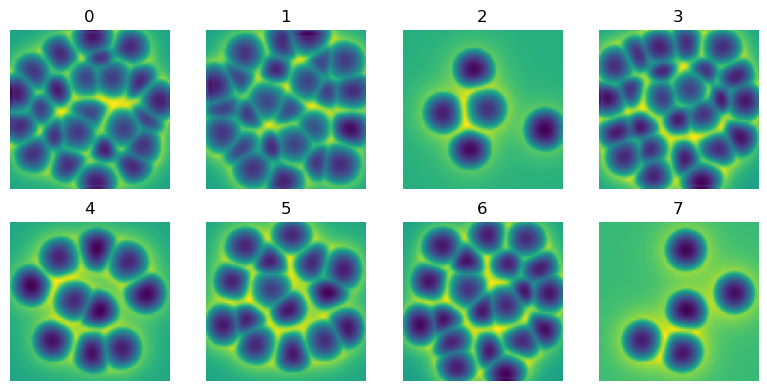

In [47]:
fig, ax  = plt.subplots(2,4, dpi=100, figsize=(8,4))
for i in range(8):
    axi = np.unravel_index(i, (2,4))
    ax[axi].imshow(z_vals[i])
    ax[axi].axis('off')
    ax[axi].set_title(i)
fig.tight_layout()

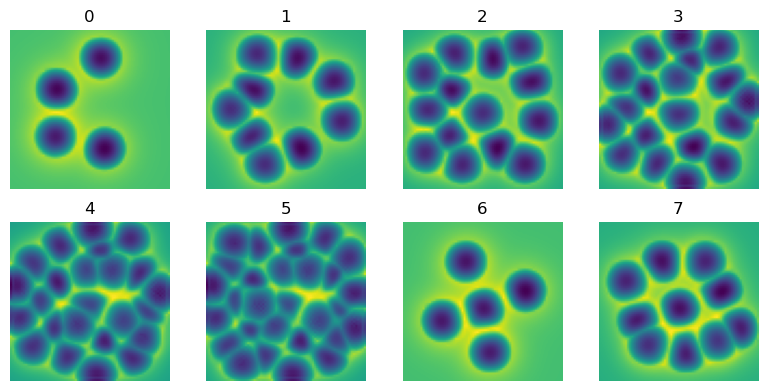

In [25]:
z = z_vals[df_meta['id'].values]
x = x_vals[df_meta['id'].values]
y = y_vals[df_meta['id'].values]

df_meta = df_meta.reset_index(drop=True)
df_meta['id'] = df_meta.index.values

fig, ax  = plt.subplots(2,4, dpi=100, figsize=(8,4))
for i in range(8):
    axi = np.unravel_index(i, (2,4))
    ax[axi].imshow(z[i])
    ax[axi].axis('off')
    ax[axi].set_title(i)
fig.tight_layout()

In [49]:
df_meta.head()

,sequence,impacts,coverage,id
0,0,4,16,0
1,0,9,33,1
2,0,14,50,2
3,0,19,66,3
4,0,24,83,4


## interpolate?


In [26]:
# TRANSPOSE:
z = np.array([zi.T for zi in z])
x = np.array([xi.T for xi in x])
y = np.array([yi.T for yi in y])

In [67]:
print('x grids:', np.array([np.array([(x[i, k,:] == np.unique(x[i])).all(0) 
                                      for k in range(x.shape[1])]).all()
                            for i in range(x.shape[0])]).all()
      )

print('y grids:', np.array([np.array([(y[i, :,k] == np.unique(y[i])).all(0) 
                                      for k in range(y.shape[1])]).all()
                            for i in range(y.shape[0])]).all()
      )

x grids: True
y grids: True


In [31]:
check = np.array([x[i] == x[0] for i in range(x.shape[0])])
print('Are all x_grids the same?', check.all())
check = np.array([y[i] == y[0] for i in range(x.shape[0])])
print('Are all y_grids the same?', check.all())

check = np.array([check_if_regulargrid(x[i], y[i])
                    for i in range(x.shape[0])])
print('Do we have regular grids:', check.all())

# Just for all purposes (must be one)
assert np.array([len(np.unique(np.diff(x[i], axis=0)))
                == 1 for i in range(x.shape[0])]).all()
assert np.array([len(np.unique(np.diff(y[i], axis=1)))
                == 1 for i in range(y.shape[0])]).all()

check = np.array([len(np.unique(np.diff(x[i], axis=1)))
                    == 1 for i in range(x.shape[0])])
print('Are all x_grids evenely spaced?', check.all())
check = np.array([len(np.unique(np.diff(y[i], axis=0)))
                    == 1 for i in range(y.shape[0])])
print('Are all y_grids evenely spaced?', check.all())

Are all x_grids the same? True
Are all y_grids the same? True
Do we have regular grids: True
Are all x_grids evenely spaced? False
Are all y_grids evenely spaced? False


# COMPATE DIFFERENT VERSIONS

## XLSV OLD

In [27]:
height = z
x_grid = x[0]
y_grid = y[0]

In [28]:
df_conv = get_descriptor_conv(z, x, y,
                              interpolation_pre=0,
                              interpolation_post=1000,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()


not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: True
Use gausian filter: True
Inteprolation postproces: 1000
Postprocessing took 32.21805691719055 seconds.
Calculating conventional parameters took 12.659082889556885 seconds.


,Sa,Sq,Sdr
count,30.000000,30.000000,30.000000
mean,0.001503,0.001843,0.044551
std,0.000292,0.000240,0.014690
min,0.000792,0.001242,0.013688
25%,0.001436,0.001808,0.035823
50%,0.001648,0.001960,0.050480
75%,0.001689,0.002005,0.055608
max,0.001778,0.002064,0.058352


In [75]:
df_merged = df_meta.merge(df_conventional,
                          on=['id'], how='outer')

<AxesSubplot:xlabel='coverage', ylabel='Sa'>

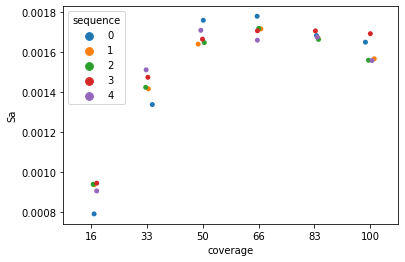

In [78]:
sns.stripplot(data=df_merged, 
              x='coverage',
              y='Sa',
              hue='sequence')

## OLD NUM_SIMULATION

In [90]:
data = np.load('./test_values/old_surface_numSimulation.npz')
z = data['values']
x = data['x_grid']
y = data['y_grid']

df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=False,
                              intepolation_post=1000,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

## OTHER VERSION

In [108]:
data = np.load('./test_values/simulationHeightmaps.npz') 
df_old = pd.read_csv('./test_values/simulations_links2files.csv')

z = data['values']
print(np.shape(z))
z = z[df_old.loc[df_old['impacts']<35, 'listposition'].values]
x = data['x_grid']
y = data['y_grid']

df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=1000,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

(116, 74, 74)
not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: True
Use gausian filter: True
Inteprolation postproces: 1000
Postprocessing took 29.905420064926147 seconds.
Calculating conventional parameters took 12.175121068954468 seconds.


,Sa,Sq,Sdr
count,30.000000,30.000000,30.000000
mean,0.001503,0.001843,0.044551
std,0.000292,0.000240,0.014690
min,0.000792,0.001242,0.013688
25%,0.001436,0.001808,0.035823
50%,0.001648,0.001960,0.050480
75%,0.001689,0.002005,0.055608
max,0.001778,0.002064,0.058352


In [107]:
df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=1000,
                              removeplane=True,
                              use_filter=False)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: True
Use gausian filter: False
Inteprolation postproces: 1000
Postprocessing took 7.070876121520996 seconds.
Calculating conventional parameters took 12.576050996780396 seconds.


,Sa,Sq,Sdr
count,30.000000,30.000000,30.000000
mean,0.002003,0.002394,0.053982
std,0.000260,0.000190,0.014616
min,0.001352,0.001930,0.021118
25%,0.001960,0.002357,0.047210
50%,0.002063,0.002437,0.060799
75%,0.002188,0.002547,0.064374
max,0.002273,0.002593,0.066500


In [110]:
df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=1000,
                              removeplane=False,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: False
Use gausian filter: True
Inteprolation postproces: 1000
Postprocessing took 26.815552949905396 seconds.
Calculating conventional parameters took 11.90619683265686 seconds.


,Sa,Sq,Sdr
count,30.000000,30.000000,30.000000
mean,0.001481,0.001830,0.044246
std,0.000286,0.000236,0.014496
min,0.000788,0.001239,0.013694
25%,0.001415,0.001796,0.035772
50%,0.001617,0.001942,0.050201
75%,0.001671,0.001999,0.055225
max,0.001746,0.002046,0.057698


In [109]:
df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=1000,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: True
Use gausian filter: True
Inteprolation postproces: 1000
Postprocessing took 28.597738027572632 seconds.
Calculating conventional parameters took 11.589176893234253 seconds.


,Sa,Sq,Sdr
count,30.000000,30.000000,30.000000
mean,0.001503,0.001843,0.044551
std,0.000292,0.000240,0.014690
min,0.000792,0.001242,0.013688
25%,0.001436,0.001808,0.035823
50%,0.001648,0.001960,0.050480
75%,0.001689,0.002005,0.055608
max,0.001778,0.002064,0.058352


In [112]:
df_conv = get_descriptor_conv(z, x, y,
                              intepolation_pre=1000,
                              intepolation_post=0,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

AssertionError: 

## MATLAB

In [105]:
data = np.load('./test_values/simulationHeightmapsMatlab.npz') 
df_old = pd.read_csv('./test_values/simulations_links2files.csv')

z = data['values']
print(np.shape(z))
z = z[df_old.loc[df_old['impacts']<35, 'listposition'].values]
print(np.shape(z))
x = data['x_grid']
y = data['y_grid']

(116, 995, 995)
(92, 995, 995)


In [106]:
df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=0,
                              removeplane=False,
                              use_filter=False)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: False
Use gausian filter: False
Inteprolation postproces: 1000
Postprocessing took 0.003170013427734375 seconds.
Calculating conventional parameters took 0.33649110794067383 seconds.


,Sa,Sq,Sdr
count,30.000000,30.000000,30.000000
mean,0.002062,0.002452,0.052791
std,0.000246,0.000188,0.013357
min,0.001493,0.002042,0.021773
25%,0.001907,0.002318,0.048062
50%,0.002112,0.002486,0.058848
75%,0.002258,0.002612,0.061831
max,0.002336,0.002675,0.064986


# OLD versions of DATA in github

In [8]:
data = pd.read_csv('../ignored_old/old_numSimulation_parameters.csv')
print(data[['Sa', 'Sq']].describe())
print(np.unique(data['processed']))

              Sa         Sq
count  92.000000  92.000000
mean    0.002003   0.002382
std     0.000233   0.000173
min     0.001355   0.001931
25%     0.001907   0.002266
50%     0.002075   0.002432
75%     0.002172   0.002519
max     0.002282   0.002622
['filtered']


In [14]:
data = np.load('../ignored_old/Old_python_scripts/old_surface_numSimulation.npz')
for key in data.keys():
    print(key)
    
z = data['values']
x = data['x_grid']
y = data['y_grid']
df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=1000,
                              removeplane=True,
                              use_filter=False)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

values
x_grid
y_grid
not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: True
Use gausian filter: False


NameError: name 'interpolation_post' is not defined

In [ ]:
df_conv = get_descriptor_conv(z, [x], [y],
                              intepolation_pre=0,
                              intepolation_post=1000,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

# OLD GITHUB VERSION

In [12]:
data = np.load('./test/surface_numSimulation.npz')

z = data['values']
x = data['x_grid']
y = data['y_grid']
df_conv = get_descriptor_conv(z, [x], [y],
                              interpolation_pre=0,
                              interpolation_post=1000,
                              removeplane=True,
                              use_filter=True)
df_conv[['Sa', 'Sq', 'Sdr']].describe()

not interpolated
Processing of the surface is done using: nom_filt
Remove a least square fitted plane from surface: True
Use gausian filter: True
Inteprolation postproces: 1000
Postprocessing took 96.20840716362 seconds.
Calculating conventional parameters took 38.575664043426514 seconds.


,Sa,Sq,Sdr
count,92.000000,92.000000,92.000000
mean,0.001523,0.001858,0.045346
std,0.000277,0.000232,0.014430
min,0.000792,0.001242,0.013688
25%,0.001502,0.001853,0.036975
50%,0.001643,0.001955,0.052437
75%,0.001697,0.002005,0.055961
max,0.001806,0.002104,0.059742
